# Mean squared error boosting

In [1]:
from support import *

In [2]:
df = data()
df

,sqfeet,rent
0,750,1160
1,800,1200
2,850,1280
3,900,1450
4,950,2000


In [3]:
eta = 1.0
M = 3
gbm = l2boost(df, 'rent', eta, M)
splits = gbm.splits()
print(gbm.splits())

df['deltas'] = df[['delta1','delta2','delta3']].sum(axis=1) # sum deltas

df

[925.0, 825.0, 925.0]


,sqfeet,rent,F0,res1,delta1,F1,res2,delta2,F2,res3,delta3,F3,deltas
0,750,1160,1418.0,-258.0,-145.5,1272.5,-112.5,-92.500000,1180.000000,-20.000000,15.416667,1195.416667,-222.583333
1,800,1200,1418.0,-218.0,-145.5,1272.5,-72.5,-92.500000,1180.000000,20.000000,15.416667,1195.416667,-222.583333
2,850,1280,1418.0,-138.0,-145.5,1272.5,7.5,61.666667,1334.166667,-54.166667,15.416667,1349.583333,-68.416667
3,900,1450,1418.0,32.0,-145.5,1272.5,177.5,61.666667,1334.166667,115.833333,15.416667,1349.583333,-68.416667
4,950,2000,1418.0,582.0,582.0,2000.0,0.0,61.666667,2061.666667,-61.666667,-61.666667,2000.000000,582.000000


In [4]:
np.set_printoptions(precision=3)
print(mse(df, M))
print(np.sqrt(mse(df, M)))
print(mae(df, M))

[94576.     9895.     4190.833  3240.139]
[307.532  99.474  64.737  56.922]
[245.6    74.     54.333  42.   ]


In [5]:
F = df[['sqfeet','rent','F0','F1','F2','F3']]
for i in range(len(F)):
    print( " & ".join([f"{int(v)}" for v in F.iloc[i,0:6]]), r"\\")

750 & 1160 & 1418 & 1272 & 1180 & 1195 \\
800 & 1200 & 1418 & 1272 & 1180 & 1195 \\
850 & 1280 & 1418 & 1272 & 1334 & 1349 \\
900 & 1450 & 1418 & 1272 & 1334 & 1349 \\
950 & 2000 & 1418 & 2000 & 2061 & 2000 \\


In [6]:
# manually print table in python
# for small phone, make 2 tables
for i in range(len(df)):
    print( " & ".join([f"{int(v)}" for v in df.iloc[i,0:4]]), r"\\")

print
for i in range(len(df)):
    print( " & ".join([f"{int(v)}" for v in df.iloc[i,4:]]), r"\\")

750 & 1160 & 1418 & -258 \\
800 & 1200 & 1418 & -218 \\
850 & 1280 & 1418 & -138 \\
900 & 1450 & 1418 & 32 \\
950 & 2000 & 1418 & 582 \\
-145 & 1272 & -112 & -92 & 1180 & -20 & 15 & 1195 & -222 \\
-145 & 1272 & -72 & -92 & 1180 & 20 & 15 & 1195 & -222 \\
-145 & 1272 & 7 & 61 & 1334 & -54 & 15 & 1349 & -68 \\
-145 & 1272 & 177 & 61 & 1334 & 115 & 15 & 1349 & -68 \\
582 & 2000 & 0 & 61 & 2061 & -61 & -61 & 2000 & 582 \\


## Plot F0 vs rent

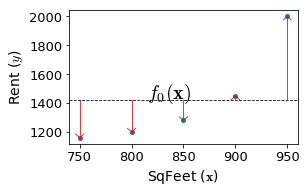

In [7]:
f0 = df.rent.mean()
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 2.5), sharex=True)
plt.tight_layout()
ax.plot(df.sqfeet,df.rent,'o', linewidth=.8, markersize=4)
ax.plot([df.sqfeet.min()-10,df.sqfeet.max()+10], [f0,f0],
         linewidth=.8, linestyle='--', c='k')
ax.set_xlim(df.sqfeet.min()-10,df.sqfeet.max()+10)
ax.text(815, f0+15, r"$f_0({\bf x})$", fontsize=20)

ax.set_ylabel(r"Rent ($y$)", fontsize=14)
ax.set_xlabel(r"SqFeet (${\bf x}$)", fontsize=14)

# draw arrows
for x,y,yhat in zip(df.sqfeet,df.rent,df.F0):
    draw_vector(ax, x, yhat, 0, y-yhat, df.rent.max()-df.rent.min())

plt.show()

## Plot delta predictions versus residuals

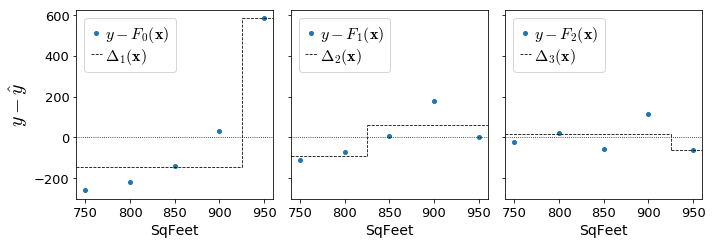

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 3.5), sharey=True)

axes[0].set_ylabel(r"$y-\hat y$", fontsize=20)
for a in range(3):
    axes[a].set_xlabel(r"SqFeet", fontsize=14)
    axes[a].set_xlim(df.sqfeet.min()-10,df.sqfeet.max()+10)

plot_stump(axes[0], df.sqfeet, df.res1, df.delta1, splits[0], stage=1)

plot_stump(axes[1], df.sqfeet, df.res2, df.delta2, splits[1], stage=2)

plot_stump(axes[2], df.sqfeet, df.res3, df.delta3, splits[2], stage=3)

plt.tight_layout()
        
plt.savefig('/tmp/t.svg')
plt.show()

In [9]:
df[['delta1','delta2','delta3']]

,delta1,delta2,delta3
0,-145.5,-92.500000,15.416667
1,-145.5,-92.500000,15.416667
2,-145.5,61.666667,15.416667
3,-145.5,61.666667,15.416667
4,582.0,61.666667,-61.666667


## Show MSE for various learning rates

In [10]:
M = 4

df_mse = pd.DataFrame(data={"stage":range(M+1)})

for eta in np.arange(.5, 1, .1):
    df = data() # fresh data
    gbm = l2boost(df, 'rent', eta, M)
    
    df_mse[f'mse_{eta:.2f}'] = mse(df, M)

df_mse

,stage,mse_0.50,mse_0.60,mse_0.70,mse_0.80,mse_0.90
0,0,94576.000000,94576.000000,94576.000000,94576.000000,94576.000000
1,1,31065.250000,23443.960000,17516.290000,13282.240000,10741.810000
2,2,11487.992188,6087.542600,3086.510621,2063.193600,2672.101788
3,3,4571.491455,2478.410696,587.736483,399.423886,1578.549751
4,4,1737.662106,580.845790,237.196006,180.572941,508.900949


[1737.6621059841593, 580.8457895600011, 237.19600554182793, 180.57294051555533, 508.9009492881273]
Best index is  3 0.7999999999999999


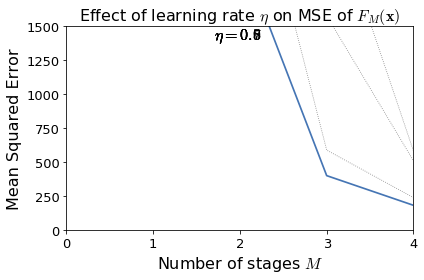

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4), sharex=True)

maxy = 1500

max_eta = 1
min_eta = .5
mins = []
for eta in np.arange(min_eta, max_eta, .1):
    mins.append( np.min(df_mse[f'mse_{eta:.2f}']) )

print (mins)
min_eta_index = np.argmin(mins)
print("Best index is ", min_eta_index, list(np.arange(min_eta, max_eta, .1))[min_eta_index])

i = 0
for eta in np.arange(min_eta, max_eta, .1):
    color = 'grey'
    lw = .8
    ls = ':'
    if i==min_eta_index:
        color = bookcolors['blue']
        lw = 1.7
        ls = '-'
    ax.plot(df_mse.stage,df_mse[f'mse_{eta:.2f}'],
            linewidth=lw,
            linestyle=ls,
            c=color)
    xloc = 1.2
    yloc = (df_mse[f'mse_{eta:.2f}'].values[1] + df_mse[f'mse_{eta:.2f}'].values[2])/2
    if yloc>maxy:
        yloc = maxy-100
        xloc +=  .5
    ax.text(xloc, yloc, f"$\\eta={eta:.1f}$",
            fontsize=16)
    i += 1

plt.axis([0,M,0,maxy])

ax.set_ylabel(r"Mean Squared Error", fontsize=16)
ax.set_xlabel(r"Number of stages $M$", fontsize=16)
ax.set_title(r'Effect of learning rate $\eta$ on MSE of $F_M({\bf x})$', fontsize=16)
ax.set_xticks(range(0,M+1))

plt.tight_layout()
plt.show()

## Show composite model

In [12]:
# Hideous manual computation of composite graph but...

M = 3
eta = 1.0
df = data()
gbm = l2boost(df, 'rent', eta, M)
df['deltas12'] = 0.7 * df[['delta1','delta2']].sum(axis=1)
df['deltas123'] = 0.7 * df[['delta1','delta2','delta3']].sum(axis=1)
df['deltas'] = 0.7 * df[['delta1','delta2','delta3']].sum(axis=1) # sum deltas

df[['sqfeet','rent','F0','delta1','delta2','delta3','deltas','deltas12','deltas123']]

,sqfeet,rent,F0,delta1,delta2,delta3,deltas,deltas12,deltas123
0,750,1160,1418.0,-145.5,-92.500000,15.416667,-155.808333,-166.600000,-155.808333
1,800,1200,1418.0,-145.5,-92.500000,15.416667,-155.808333,-166.600000,-155.808333
2,850,1280,1418.0,-145.5,61.666667,15.416667,-47.891667,-58.683333,-47.891667
3,900,1450,1418.0,-145.5,61.666667,15.416667,-47.891667,-58.683333,-47.891667
4,950,2000,1418.0,582.0,61.666667,-61.666667,407.400000,450.566667,407.400000


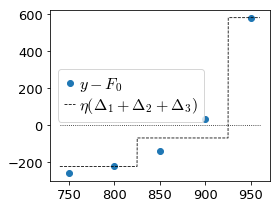

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 3))

plot_deltas(ax, df, gbm, 3)

plt.tight_layout()
plt.show()

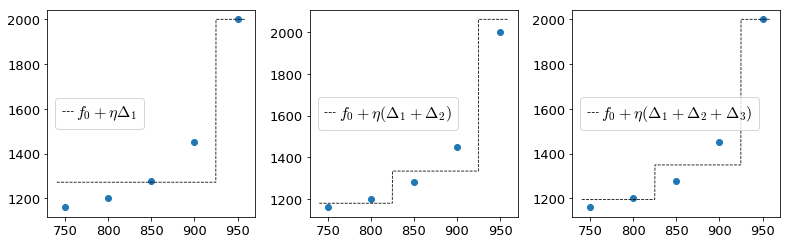

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(11.1, 3.5))

plot_composite(axes[0], df, gbm, 1)
plot_composite(axes[1], df, gbm, 2)
plot_composite(axes[2], df, gbm, 3)

plt.tight_layout()
plt.savefig('/tmp/u.svg')
plt.show()